In [12]:
import pandas as pd
import browser_cookie3
from datetime import datetime, date
import matplotlib.pyplot as plt
import numpy as np

[autoreload of vanguard.vg_holdings failed: Traceback (most recent call last):
  File "C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 459, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\chris\trade\curr_pos\vanguard\vg_holdings.py", line 21, in <module>
    from vg_all_funds import get_vanguard_auth
ModuleNotFoundError: No module named 'vg_all_funds'
]


In [16]:
%load_ext autoreload
%autoreload 2

from vanguard.vg_holdings import (
    parallel_get_portfolio_data_api,
    single_get_portfolio_data_api,
    get_portfolio_data_button,
    get_fund_cash_flow_data,
    run_in_parallel,
    Asset,
    ETFInfo,
)

from vanguard.vg import get_holding_file_path_by_ticker

from Bond import Bond, ZeroCouponBond

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
cj = browser_cookie3.chrome()
clean_path = r"C:\Users\chris\trade\curr_pos\vanguard\vg_funds_holdings_clean_data"

In [18]:
all_funds_summary_df = pd.read_excel(r'C:\Users\chris\trade\curr_pos\vanguard\vg_funds_summary\2023-10-27_vg_fund_info.xlsx')
all_funds_summary_dict = all_funds_summary_df.to_dict(orient='records')

In [19]:
def calculate_maturity(date_string):
    try:
        maturity_date = datetime.strptime(date_string, "%m/%d/%Y")
        current_date = datetime.now()
        days_to_maturity = (maturity_date - current_date).days
        years_to_maturity = days_to_maturity / 365.0
        return years_to_maturity
    except ValueError as e:
        print(f"Invalid date format: {e}")
        return None


tickers = ['EDV']
ticker_file_paths = [get_holding_file_path_by_ticker(x) for x in tickers]
ticker_holding_dfs = { x.split('_')[1]: pd.read_excel(x)  for x in ticker_file_paths }

# for ticker in ticker_holding_dfs.keys():
#     df = ticker_holding_dfs[ticker]
    
#     df['couponRate'] = df['couponRate'].apply(lambda x: x / 100)
#     df['maturityDate'] = df['maturityDate'].apply(calculate_maturity)
    
#     df['YTM'] = df.apply(lambda row: Bond.calc_YTM(row['faceAmount'], row['couponRate'], row['marketValue'], row['maturityDate'], n=1), axis=1)
#     df['currentYield'] = df.apply(lambda row: Bond.calc_current_yield(row['faceAmount'], row['couponRate'], row['marketValue']), axis=1)
#     df['macaulayDuration'] = df.apply(lambda row: Bond.calc_macaulay_duration(row['faceAmount'], row['couponRate'], row['marketValue'], row['maturityDate'], row['YTM'], n=1), axis=1)
#     df['modifiedDuration'] = df.apply(lambda row: Bond.calc_modifed_duration(row['faceAmount'], row['couponRate'], row['marketValue'], row['maturityDate'], n=1), axis=1)
#     df['convexity'] = df.apply(lambda row: Bond.calc_convexity(row['faceAmount'], row['couponRate'], row['marketValue'], row['maturityDate'], n=1), axis=1)

for ticker in ticker_holding_dfs.keys():
    df = ticker_holding_dfs[ticker]
    
    df['couponRate'] = df['couponRate'].apply(lambda x: x / 100)
    df['maturityDate'] = df['maturityDate'].apply(calculate_maturity)
    df['YTM'] = df.apply(lambda row: ZeroCouponBond.calc_YTM(row['faceAmount'], row['marketValue'], row['maturityDate']), axis=1)
    df['macaulayDuration'] = df.apply(lambda row: ZeroCouponBond.calc_macaulay_duration(row['maturityDate']), axis=1)
    df['modifiedDuration'] = df.apply(lambda row: ZeroCouponBond.calc_modified_duration(row['maturityDate'], row['YTM']), axis=1)
    df['convexity'] = df.apply(lambda row: ZeroCouponBond.calc_convexity(row['faceAmount'], row['marketValue'], row['maturityDate']), axis=1)
    df['marketPrice'] = df.apply(lambda row: ZeroCouponBond.calc_market_price(row['faceAmount'], row['YTM'], row['maturityDate']), axis=1)



In [20]:
dict = [x for x in all_funds_summary_dict if x['ticker'] in tickers]
summary_df = pd.DataFrame(dict).transpose()
summary_df.reset_index(inplace=True)
summary_df.columns = summary_df.iloc[0]  # Setting the first row as column headers
summary_df = summary_df.drop(0)

file_name = 'TREASURY_ETF_1015-2023.xlsx' # etf_report.xlsx'
with pd.ExcelWriter(file_name) as writer:
    summary_df.to_excel(writer, sheet_name="summary", index=False)
    [df.to_excel(writer, sheet_name=f"{ticker}_holdings", index=False) for ticker, df in ticker_holding_dfs.items()]

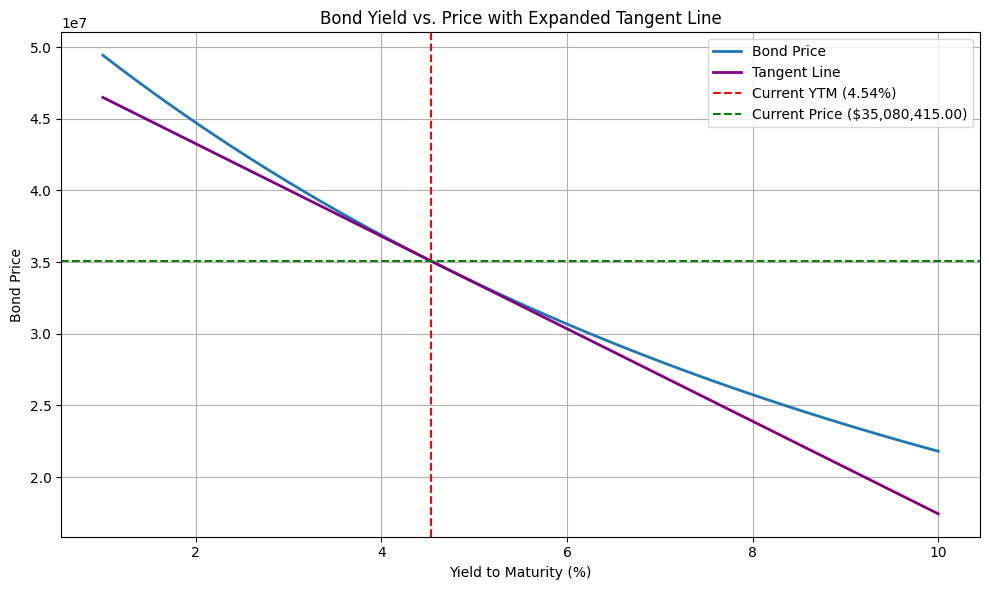

In [21]:
market_value = 35080415
face_value = 35195900
years_to_maturity = 12.3424657534247
annual_coupon_rate = 0.045
yield_to_maturity = 0.045352992275075
macualay_duration = 9.61713347770106
modified_duration = 9.19989089692145
convexity = 107.183868642499

# Generate a range of YTM values from 1% to 10%
ytm_range = np.linspace(0.01, 0.10, 100)

def calculate_bond_price(ytm, face_value, annual_coupon_rate, years_to_maturity):
    C = annual_coupon_rate * face_value  # Annual coupon payment
    n = years_to_maturity  # Number of periods
    P = (C * (1 - (1 + ytm)**-n) / ytm) + (face_value / (1 + ytm)**n)
    return P
bond_prices = [calculate_bond_price(ytm, face_value, annual_coupon_rate, years_to_maturity) for ytm in ytm_range]

D_mod = modified_duration
P_current = market_value  
m = -D_mod * P_current

# Define the equation of the tangent line
def tangent_line(x, x1, y1, m):
    return m * (x - x1) + y1

x_tangent_expanded = np.linspace(0.01, 0.10, 100)  
y_tangent_expanded = tangent_line(x_tangent_expanded, yield_to_maturity, P_current, m)

plt.figure(figsize=(10, 6))
plt.plot(ytm_range*100, bond_prices, label="Bond Price", linewidth=2)
plt.plot(x_tangent_expanded*100, y_tangent_expanded, label="Tangent Line", linestyle='-', linewidth=2, color='purple')
plt.axvline(x=yield_to_maturity*100, color='r', linestyle='--', label=f'Current YTM ({yield_to_maturity*100:.2f}%)')
plt.axhline(y=market_value, color='g', linestyle='--', label=f'Current Price (${market_value:,.2f})')

plt.xlabel("Yield to Maturity (%)")
plt.ylabel("Bond Price")
plt.title("Bond Yield vs. Price with Expanded Tangent Line")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
def calculate_modified_duration(years_to_maturity, yield_to_maturity):
    macaulay_duration = years_to_maturity
    modified_duration = macaulay_duration / (1 + yield_to_maturity)
    return modified_duration

calculate_modified_duration(19.8082191780822, 0.05231)

18.8235588163965